# Setup

In [1]:
pip install -r ../../requirements.txt

/bin/bash: /anaconda/envs/jupyter_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple/, https://****@pkgs.dev.azure.com/parsionate-ai/ps-libraries/_packaging/pypi-feed/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [5]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-10 16:38:49.699612: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [6]:
config = json.load(open("./configs/mnn_btl_mscoco_supercategory.json"))

In [7]:
tmp_path = "/mnt/azmnt/mscoco"

In [8]:
train = pd.read_csv(os.path.join(config["data"]["path"], "train2014_supercategory.csv"))
train = train.drop({"Unnamed: 0"}, axis=1)
train = train[['description', 'path', 'category', 'label']]
train

,description,path,category,label
0,three buses driving up a road towards a man on...,COCO_train2014_000000109588.jpg,animal,0
1,there is a elephant that seems to be doing a t...,COCO_train2014_000000274467.jpg,person,1
2,a kfc bucket sign atop a tall post.,COCO_train2014_000000262541.jpg,person,0
3,many people walking holding luggage bags in a ...,COCO_train2014_000000277677.jpg,vehicle,0
4,a man is eating grating up carrots at a table.,COCO_train2014_000000410779.jpg,kitchen,1
...,...,...,...,...
795025,skiier riding down in this section of the moun...,COCO_train2014_000000298297.jpg,person,0
795026,two giraffes standing over each other in a bui...,COCO_train2014_000000222948.jpg,animal,1
795027,small tin can with mixed vegetables inside the...,COCO_train2014_000000261648.jpg,kitchen,1
795028,two giraffes some rocks and trees in their pen,COCO_train2014_000000294834.jpg,animal,1


In [9]:
val = pd.read_csv(os.path.join(config["data"]["path"], "val2014_supercategory.csv"))
val = val.drop({"Unnamed: 0"}, axis=1)
val = val[['description', 'path', 'category', 'label']]
val

,description,path,category,label
0,two black bears in a wooded area at night.,COCO_val2014_000000071756.jpg,animal,1
1,"this is a bathroom with a toilet, counter and ...",COCO_val2014_000000384850.jpg,furniture,1
2,a photograph of an outside with numerous thing...,COCO_val2014_000000572561.jpg,furniture,0
3,a man sets up his ties at his store.,COCO_val2014_000000083476.jpg,vehicle,0
4,two apple computers are on a white desk,COCO_val2014_000000001503.jpg,electronic,1
...,...,...,...,...
392691,a bowl of soup contains fresh vegetables and a...,COCO_val2014_000000068217.jpg,sports,0
392692,a young boy throwing a baseball in a baseball ...,COCO_val2014_000000410493.jpg,furniture,0
392693,man in grey shirt laying down in a bed with do...,COCO_val2014_000000015565.jpg,person,0
392694,"a room with a bed, lamp, curtains and pillows ...",COCO_val2014_000000542205.jpg,electronic,0


In [10]:
img_train = train[["path"]]  # two brackets for keeping the column name
text_train = train["description"]
categories_train = train[["category"]]
labels_train = train[["label"]]

In [11]:
img_val = val[["path"]]  # two brackets for keeping the column name
text_val = val["description"]
categories_val = val[["category"]]
labels_val = val[["label"]]

# Loading data

# Text processing

## Tokenize texts

In [12]:
tk = CharTokenizer(config["data"]["alphabet"])
text_train = tk.tokenize(text_train)
text_train.shape

(795030, 1014)

In [13]:
text_val = tk.tokenize(text_val)
text_val.shape

(392696, 1014)

## Create embedding weights

In [14]:
weights = tk.create_embedding_weights()
weights.shape

(66, 65)

# Image processing

## Load image model

In [15]:
from utils.img_processing import load_img_model, create_embeddings_from

In [16]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [17]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img_train = create_embeddings_from(img_model,
                                    img_train,
                                    os.path.join(tmp_path,
                                                "train2014"),
                                    batch_size=1024)

Found 795030 validated image filenames.


In [18]:
img_train.shape

(795030, 576)

In [19]:
img_val = create_embeddings_from(img_model,
                                    img_val,
                                    os.path.join(tmp_path,
                                                "val2014"),
                                    batch_size=1024)

Found 392696 validated image filenames.


In [20]:
img_val.shape

(392696, 576)

# Save embeddings

In [21]:
save_path = os.path.join(tmp_path,
                         f"embeddings/{img_model.name}")

In [22]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img_train.npy", img_train)
np.save(f"{save_path}/text_train.npy", text_train)
train.to_csv(f"{save_path}/train.csv")

In [23]:
np.save(f"{save_path}/img_val.npy", img_val)
np.save(f"{save_path}/text_val.npy", text_val)
val.to_csv(f"{save_path}/val.csv")

## Verify import

In [24]:
train = pd.read_csv(f"{save_path}/train.csv")
train = train.drop({"Unnamed: 0"}, axis=1)
train

,description,path,category,label
0,three buses driving up a road towards a man on...,COCO_train2014_000000109588.jpg,animal,0
1,there is a elephant that seems to be doing a t...,COCO_train2014_000000274467.jpg,person,1
2,a kfc bucket sign atop a tall post.,COCO_train2014_000000262541.jpg,person,0
3,many people walking holding luggage bags in a ...,COCO_train2014_000000277677.jpg,vehicle,0
4,a man is eating grating up carrots at a table.,COCO_train2014_000000410779.jpg,kitchen,1
...,...,...,...,...
795025,skiier riding down in this section of the moun...,COCO_train2014_000000298297.jpg,person,0
795026,two giraffes standing over each other in a bui...,COCO_train2014_000000222948.jpg,animal,1
795027,small tin can with mixed vegetables inside the...,COCO_train2014_000000261648.jpg,kitchen,1
795028,two giraffes some rocks and trees in their pen,COCO_train2014_000000294834.jpg,animal,1


In [25]:
img_train = np.load(f"{save_path}/img_train.npy", allow_pickle=True)
img_train.shape

(795030, 576)

In [26]:
text_train = np.load(f"{save_path}/text_train.npy", allow_pickle=True)
text_train.shape

(795030, 1014)

In [27]:
val = pd.read_csv(f"{save_path}/val.csv")
val = val.drop({"Unnamed: 0"}, axis=1)
val

,description,path,category,label
0,two black bears in a wooded area at night.,COCO_val2014_000000071756.jpg,animal,1
1,"this is a bathroom with a toilet, counter and ...",COCO_val2014_000000384850.jpg,furniture,1
2,a photograph of an outside with numerous thing...,COCO_val2014_000000572561.jpg,furniture,0
3,a man sets up his ties at his store.,COCO_val2014_000000083476.jpg,vehicle,0
4,two apple computers are on a white desk,COCO_val2014_000000001503.jpg,electronic,1
...,...,...,...,...
392691,a bowl of soup contains fresh vegetables and a...,COCO_val2014_000000068217.jpg,sports,0
392692,a young boy throwing a baseball in a baseball ...,COCO_val2014_000000410493.jpg,furniture,0
392693,man in grey shirt laying down in a bed with do...,COCO_val2014_000000015565.jpg,person,0
392694,"a room with a bed, lamp, curtains and pillows ...",COCO_val2014_000000542205.jpg,electronic,0


In [28]:
img_val = np.load(f"{save_path}/img_val.npy", allow_pickle=True)
img_val.shape

(392696, 576)

In [29]:
text_val = np.load(f"{save_path}/text_val.npy", allow_pickle=True)
text_val.shape

(392696, 1014)

# Train-Test Split

## Split into ground truth/false samples

In [30]:
ground_truth_train = train[train["label"] == 1]
train_false = train[train["label"] == 0]
train = ground_truth_train

ground_truth_val = val[val["label"] == 1]
val_false = val[val["label"] == 0]
val = ground_truth_val

In [31]:
img_train_false = img_train[train_false.index]
text_train_false = text_train[train_false.index]

img_val_false = img_val[val_false.index]
text_val_false = text_val[val_false.index]

In [32]:
img_train = img_train[train.index]
text_train = text_train[train.index]

img_val = img_val[val.index]
text_val = text_val[val.index]

In [33]:
train = train.reset_index(drop=True)
train_false = train_false.reset_index(drop=True)

val = val.reset_index(drop=True)
val_false = val_false.reset_index(drop=True)

## Ground truth

In [34]:
train["category_count"] = train.groupby(
    ["category"])["category"].transform("count")

train = train[train["category_count"] > config["data"]["cls"]]

In [35]:
val["category_count"] = val.groupby(
    ["category"])["category"].transform("count")

val = val[val["category_count"] > config["data"]["cls"]]

In [36]:
# Update both columns
categories_train = train[["category"]]

labels_train = train[["label"]]

In [37]:
# Update both columns
categories_val = val[["category"]]

labels_val = val[["label"]]

In [38]:
img_train = img_train[train.index]
text_train = text_train[train.index]

img_val = img_val[val.index]
text_val = text_val[val.index]

## False samples

In [39]:
train_false["category_count"] = train_false.groupby(
    ["category"])["category"].transform("count")

train_false = train_false[train_false["category_count"] > config["data"]["cls"]]

In [40]:
val_false["category_count"] = val_false.groupby(
    ["category"])["category"].transform("count")

val_false = val_false[val_false["category_count"] > config["data"]["cls"]]

In [41]:
# Update both columns
categories_train_false = train_false[["category"]]

labels_train_false = train_false[["label"]]

In [42]:
# Update both columns
categories_val_false = val_false[["category"]]

labels_val_false = val_false[["label"]]

In [43]:
img_train_false = img_train_false[train_false.index]
text_train_false = text_train_false[train_false.index]

img_val_false = img_val_false[val_false.index]
text_val_false = text_val_false[val_false.index]

# Save Char CNN config

In [44]:
from models.char_cnn_zhang import CharCNNZhang

In [45]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [46]:
char_cnn = CharCNNZhang(**char_cnn_config)

# Build MNN-BTL Model

In [47]:
from models.mnn_btl import MNNBTL
from utils.metrics import create_metrics

In [48]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["img_fc_layers"],
    "txt_fc_layers": config["model"]["txt_fc_layers"],
    "extended": False,
}

In [49]:
mnn_btl = MNNBTL(
    head_config=head_config,
    char_cnn=char_cnn.model,
    learning_rate=config["model"]["training"]["learning_rate"])

In [50]:
mnn_btl.model.summary(expand_nested=True)

Model: "MNN_BTL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input_Head_Outer (InputL  [(None, 576)]       0           []                               
 ayer)                                                                                            
                                                                                                  
 Text_Input_Head_Outer (InputLa  [(None, 1014)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Image_CNN (Functional)         (None, 512)          1115648     ['Image_Input_Head_Outer[0][0]'] 
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

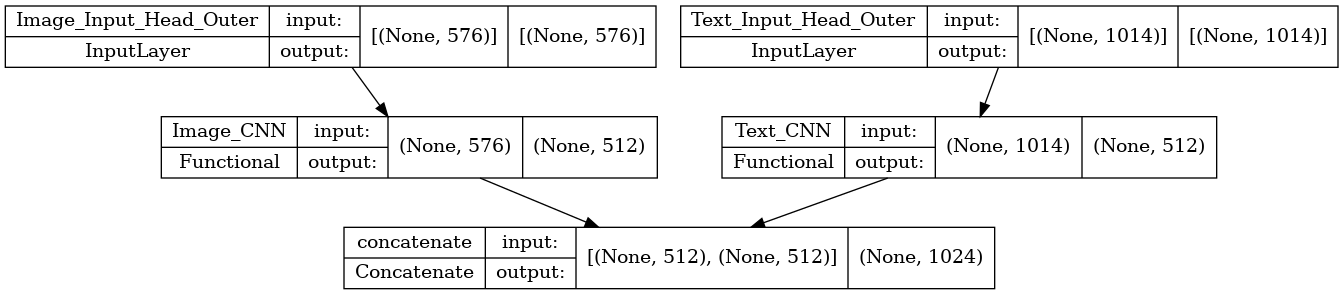

In [51]:
# "Head"

tf.keras.utils.plot_model(mnn_btl.model,
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

# Callbacks

In [52]:
from utils.metrics import create_callbacks

In [53]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [54]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"],
    patience=10)

# Class weights

In [55]:
from sklearn.utils import class_weight

In [56]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=categories_train["category"].unique(),
                                                 y=categories_train["category"])
len(class_weights)

12

In [57]:
class_weights_dict = {}
class_weights_dict_transform = {}
i = 0

for pt, cw in zip(categories_train["category"].unique(), class_weights):
    class_weights_dict[i] = cw
    class_weights_dict_transform[pt] = i
    i += 1
    
len(class_weights_dict)

12

In [58]:
len(class_weights_dict_transform)

12

In [59]:
categories_train["category_transform"] = categories_train["category"].apply(lambda x: class_weights_dict_transform[x])
categories_train

/tmp/ipykernel_162128/3000338905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categories_train["category_transform"] = categories_train["category"].apply(lambda x: class_weights_dict_transform[x])


,category,category_transform
0,person,0
1,kitchen,1
2,person,0
3,vehicle,2
4,animal,3
...,...,...
397510,indoor,4
397511,animal,3
397512,animal,3
397513,kitchen,1


In [60]:
class_weights_dict[0]

0.3334700718758179

# Training

In [61]:
history = mnn_btl.model.fit(
    x=[img_train, text_train],
    y=categories_train["category_transform"],
    epochs=config["model"]["training"]["epochs"],
    validation_data=([img_val, text_val], labels_val),
    batch_size=config["model"]["training"]["batch_size"],
    class_weight=class_weights_dict,
    callbacks=callbacks)

Epoch 1/10
3106/3106 [==============================] - ETA: 0s - loss: 6.9454

2023-06-10 18:34:09.348570: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_MSCOCO_Supercategory/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_MSCOCO_Supercategory/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


3106/3106 [==============================] - 134s 42ms/step - loss: 6.9454 - val_loss: 2.6060
Epoch 2/10
3105/3106 [============================>.] - ETA: 0s - loss: 1.0445

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_MSCOCO_Supercategory/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_MSCOCO_Supercategory/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


3106/3106 [==============================] - 130s 42ms/step - loss: 1.0443 - val_loss: 0.2229
Epoch 3/10
3106/3106 [==============================] - ETA: 0s - loss: 0.1005

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_MSCOCO_Supercategory/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_MSCOCO_Supercategory/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


3106/3106 [==============================] - 130s 42ms/step - loss: 0.1005 - val_loss: 0.0694
Epoch 4/10
3105/3106 [============================>.] - ETA: 0s - loss: 0.0687

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_MSCOCO_Supercategory/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_MSCOCO_Supercategory/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


3106/3106 [==============================] - 130s 42ms/step - loss: 0.0687 - val_loss: 0.0693
Epoch 5/10
3106/3106 [==============================] - 125s 40ms/step - loss: 0.0687 - val_loss: 0.0693
Epoch 6/10
3106/3106 [==============================] - 125s 40ms/step - loss: 0.0687 - val_loss: 0.0693
Epoch 7/10
3105/3106 [============================>.] - ETA: 0s - loss: 0.0687

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_MSCOCO_Supercategory/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_MSCOCO_Supercategory/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


3106/3106 [==============================] - 130s 42ms/step - loss: 0.0687 - val_loss: 0.0693
Epoch 8/10
3106/3106 [==============================] - 125s 40ms/step - loss: 0.0687 - val_loss: 0.0693
Epoch 9/10
3106/3106 [==============================] - 125s 40ms/step - loss: 0.0687 - val_loss: 0.0693
Epoch 10/10
3106/3106 [==============================] - 125s 40ms/step - loss: 0.0687 - val_loss: 0.0693


# Evaluation

## Plot loss and metrics

In [62]:
from utils.metrics import plot_metrics

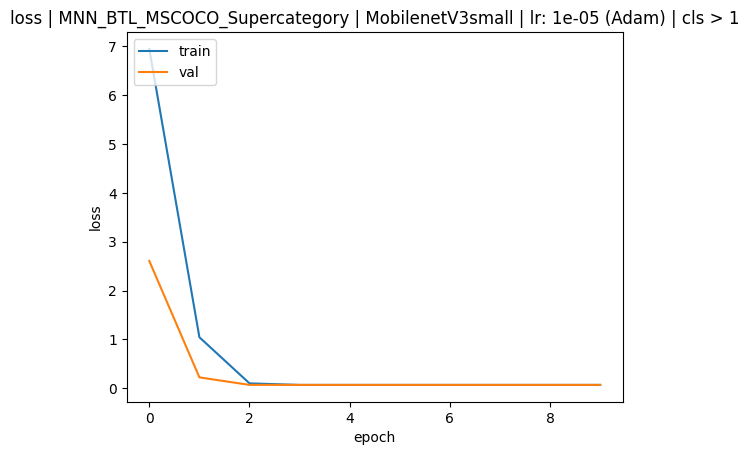

In [63]:
plot_metrics(history.history, [],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [64]:
from utils.metrics import evaluate

In [65]:
val_merged = pd.concat([val.reset_index(drop=True), val_false.reset_index(drop=True)])
img_val_merged = np.concatenate([img_val, img_val_false])
text_val_merged = np.concatenate([text_val, text_val_false])
print(val_merged.shape, img_val_merged.shape, text_val_merged.shape)

(392696, 5) (392696, 576) (392696, 1014)


In [66]:
evaluate(mnn_btl.model, [img_val_merged, text_val_merged], val_merged[["label"]], log_dir, model_name,
         img_model.name, optimizer_name, learning_rate, config["data"]["cls"], triplet_model=True)

392696/392696 [==============================] - 651s 2ms/step - loss: 0.0689
